# Задача 5. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

# Подготовка окружения

In [82]:
import time

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances_argmin
import matplotlib.pyplot as plt

from itertools import product

from sklearn.base import clone
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score
)

from sklearn.cluster import KMeans, DBSCAN

# Датасет
В качестве датасета был выбран датасет MNIST - это классический датасет, содержащий 70 000 изображений рукописных цифр от 0 до 9. Каждое изображение имеет размер 28×28 пикселей (784 признака на каждый образец) в градациях серого (1 канал) и представлено в виде матрицы с значениями яркости от 0 до 255. Датасет разделён на 60 000 тренировочных и 10 000 тестовых примеров. Метки — это соответствующие цифры от 0 до 9.

In [7]:
kp = kagglehub.dataset_download("oddrationale/mnist-in-csv")
path = Path(kp)
path_to_train = path / "mnist_train.csv"

In [9]:
df = pd.read_csv(path_to_train, dtype={'label': 'int8'})

Y = df.pop('label')
X = df.astype('uint8')

# Анализ данных

### Просмотр данных

In [18]:
X.head(10)

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df.shape

(60000, 784)

Выполним проверку на наличие NaN-значений.

In [20]:
for column in df.columns:
    if df[column].isna().sum() != 0:
        print(f"{column}: {df[column].isna().sum()}")

В результате, колонок, содержащих NaN-значения не обнаружено.

### Распределение классов
Посчитаем, сколько примеров каждой цифры содержит датасет

In [21]:
class_distribution = Y.value_counts().sort_index()
print("Распределение классов:")
print(class_distribution)

Распределение классов:
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


На обучающей части MNIST приблизительно поровну объектов каждого класса (в среднем 6000 примеров каждой цифры). Таким образом, будем считать, что датасет достаточно сбалансирован по классам.

### Примеры изображений
Рассмотрим несколько примеров написания цифр из каждого класса.

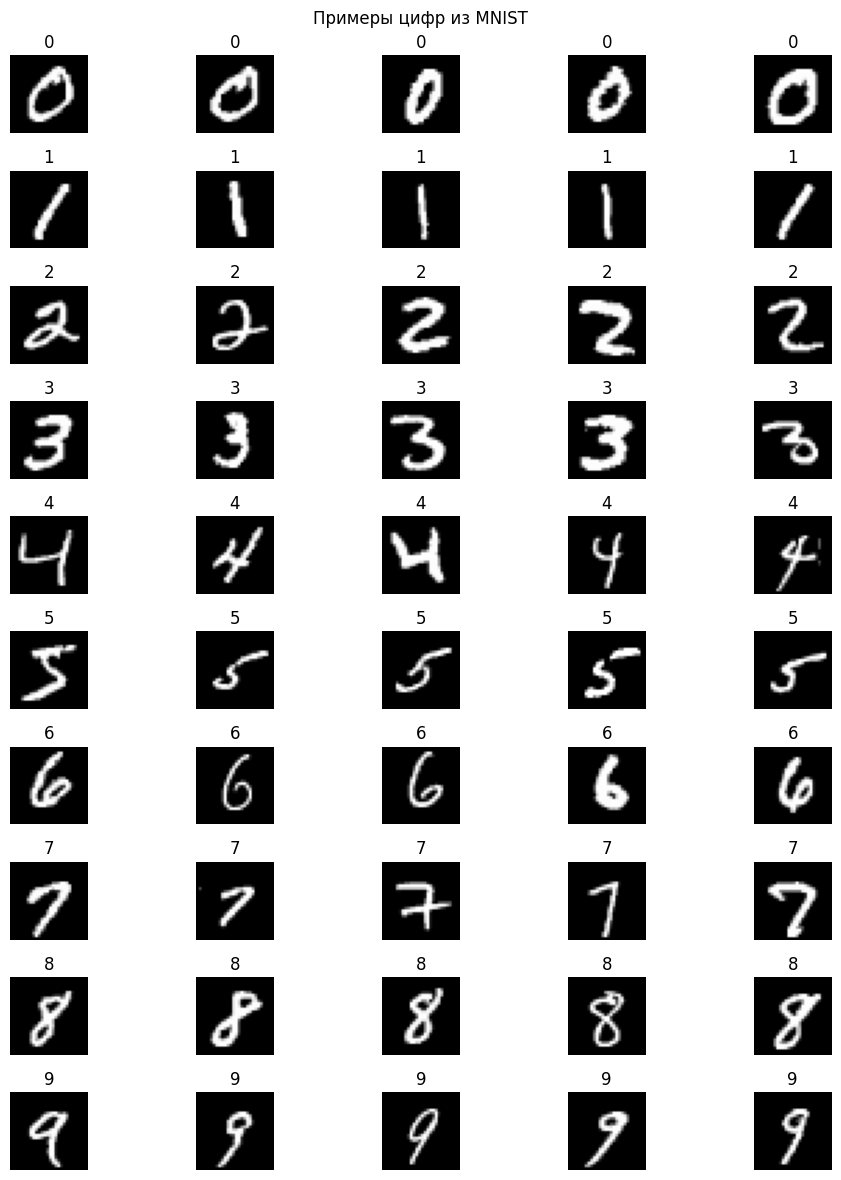

In [22]:
plt.figure(figsize=(10, 12))
X_array = X.values
Y_array = Y.values

for digit in range(10):
    idxs = np.where(Y_array == digit)[0][:5]
    for j, idx in enumerate(idxs):
        plt.subplot(10, 5, digit*5 + j + 1)
        plt.imshow(X_array[idx].reshape(28, 28), cmap='gray')
        plt.title(str(digit))
        plt.axis('off')
plt.suptitle("Примеры цифр из MNIST")
plt.tight_layout()
plt.show()

### Распределение интенсивностей пикселей

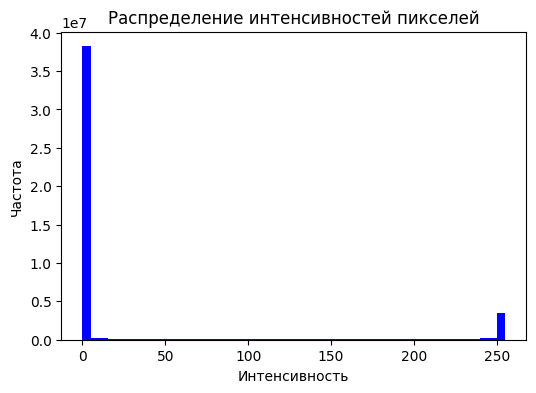

In [23]:
plt.figure(figsize=(6,4))
plt.hist(X.values.ravel(), bins=50, color='blue')
plt.title("Распределение интенсивностей пикселей")
plt.xlabel("Интенсивность")
plt.ylabel("Частота")
plt.show()

Характерно пиковое распределение вокруг 0 (фоновые пиксели) и «хвост» по большим значениям (чернила цифр). Средняя яркость каждого изображения и дисперсия пикселей будут разными для разных цифр, но в целом цифры имеют контрастный вид на чистом фоне.

## Снижение размерности

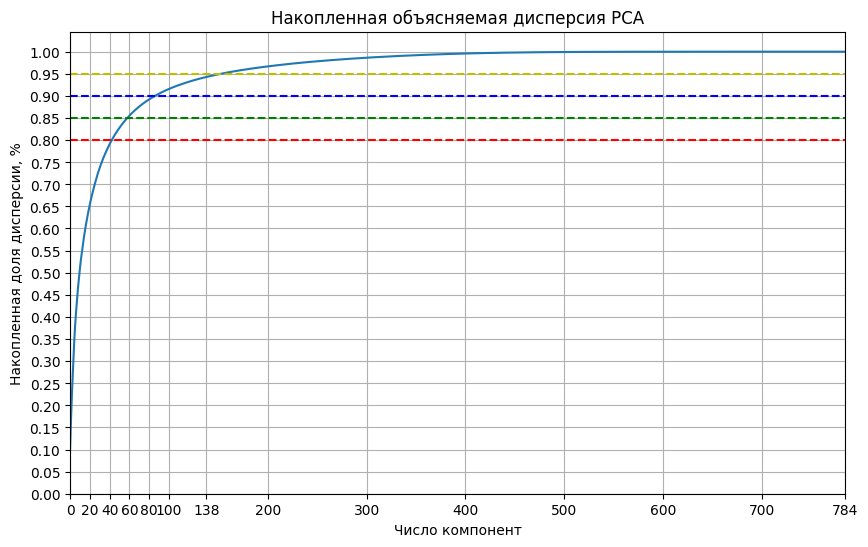

In [66]:
pca = PCA()
pca.fit(X)
cumvar = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumvar)

plt.yticks(np.arange(0, 1.0001, 0.05))
plt.xticks([*plt.xticks()[0], 20, 40, 60, 80, 138, 784])
plt.xlim(0, 784)

plt.axhline(0.8, color='r', linestyle='--', label='80% дисперсии')
plt.axhline(0.85, color='g', linestyle='--', label='85% дисперсии')
plt.axhline(0.90, color='b', linestyle='--', label='90% дисперсии')
plt.axhline(0.95, color='y', linestyle='--', label='95% дисперсии')

plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля дисперсии, %")
plt.title("Накопленная объясняемая дисперсия PCA")

plt.grid(True)

plt.show()

График показывает, как количество главных компонент влияет на долю объяснённой дисперсии.
Он демонстрирует компромисс между сокращением размерности и сохранением информативности данных.

* 40 компонент объясняют ~80% дисперсии
* 60 компонент покрывают более 85% изменчивости данных
* 80 компонент достигают 90% объяснённой дисперсии
* 138 компонент позволяют сохранить 95% исходной информации

Начиная с размерности 400 компонент, дальнейшее увеличение количества признаков не приводит к существенному росту объяснённой дисперсии.

## Визуализация данных со снижением размерности
Проведем визуализацию данных с использованием методов снижения размерности."
### PCA

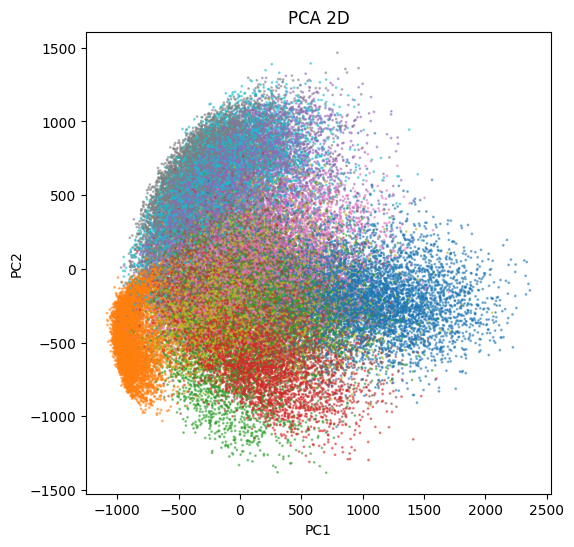

In [73]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y, cmap='tab10', s=1, alpha=0.5)
plt.title("PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

На графике четко выделяются четыре обособленных кластера, однако в центральной области наблюдается значительное перекрытие классов, что затрудняет их идентификацию.

### TSNE

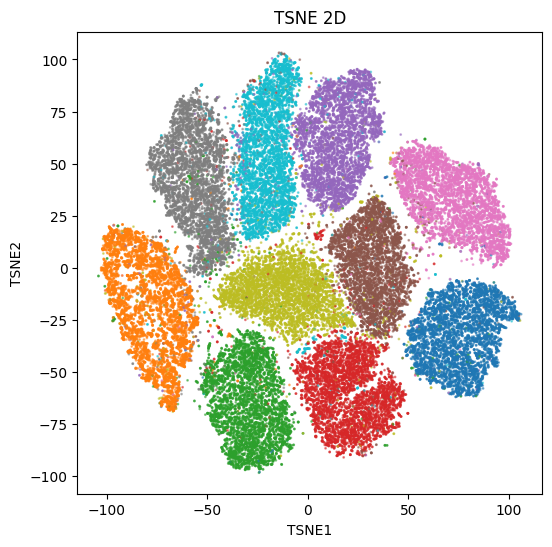

In [75]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y, cmap='tab10', s=1, alpha=0.5)
plt.title("TSNE 2D")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

Как видно на графике, данные образуют 10 хорошо различимых групп, что точно отражает реальное количество классов в рассматриваемой задаче классификации.

## Реализация и обучение
### Собственная реализация KMeans

In [91]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, tol=1e-3, random_state=None, max_iter=1000):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state
        self.max_iter = max_iter

    def fit(self, x, y=None):
        x = check_array(x)
        self.n_features_in_ = x.shape[1]
        self.random_state_ = check_random_state(self.random_state)

        self._init_centroids(x)
        for self.n_iter_ in range(1, self.max_iter + 1):
            labels = pairwise_distances_argmin(x, self.cluster_centers_)
            new_centers = self._compute_centroids(x, labels)

            shift = np.linalg.norm(self.cluster_centers_ - new_centers, axis=1).max()
            self.cluster_centers_ = new_centers
            self.labels_ = labels

            if shift <= self.tol:
                break

        return self

    def predict(self, x):
        check_is_fitted(self, "cluster_centers_")
        x = check_array(x)
        return pairwise_distances_argmin(x, self.cluster_centers_)

    def _init_centroids(self, x):
        indices = self.random_state_.choice(len(x), self.n_clusters, replace=False)
        self.cluster_centers_ = x[indices]

    def _compute_centroids(self, x, labels):
        new_centers = np.empty((self.n_clusters, self.n_features_in_))
        for i in range(self.n_clusters):
            points = x[labels == i]
            if len(points) > 0:
                new_centers[i] = points.mean(axis=0)
            else:
                new_centers[i] = x[self.random_state_.randint(0, len(x))]
        return new_centers

### Подбор параметров

In [92]:
def list_parameter_sets(param_grid):
    if not param_grid:
        return [{}]
    keys, values = zip(*param_grid.items())
    return [dict(zip(keys, combination)) for combination in product(*values)]

In [93]:
def evaluate_model(model, data, true_labels, param_sets):
    best_scores = {
        "ARI": {"score": -np.inf, "params": None, "time": None},
        "AMI": {"score": -np.inf, "params": None, "time": None},
        "FMI": {"score": -np.inf, "params": None, "time": None},
    }

    for params in param_sets:
        estimator = clone(model).set_params(**params)
        start = time.perf_counter()
        predicted = estimator.fit_predict(data)
        duration = time.perf_counter() - start

        scores = {
            "ARI": adjusted_rand_score(true_labels, predicted),
            "AMI": adjusted_mutual_info_score(true_labels, predicted),
            "FMI": fowlkes_mallows_score(true_labels, predicted),
        }

        for metric, value in scores.items():
            if value > best_scores[metric]["score"]:
                best_scores[metric] = {"score": value, "params": params, "time": duration}

    return best_scores

In [94]:
def benchmark_clustering(estimator, param_grid, datasets, labels_list, output_path):
    results = []
    param_sets = list_parameter_sets(param_grid)
    output_path = Path(output_path)

    for data, true_labels in zip(datasets, labels_list):
        best = evaluate_model(estimator, data, true_labels, param_sets)

        result = {
            "Model": estimator.__class__.__name__,
            "Features": data.shape[1],
            "Mean Time (s)": np.mean([best[m]["time"] for m in best]),
            "ARI": best["ARI"]["score"],
            "AMI": best["AMI"]["score"],
            "FMI": best["FMI"]["score"],
        }

        print(result)
        results.append(result)

    df = pd.DataFrame(results)
    df.to_csv(output_path, mode="a", header=not output_path.exists(), index=False)

In [ ]:
CLUSTERS = 10
OUTPUT_FILE = Path("clustering_benchmark.csv")

reductions = [PCA(n_components=n).fit_transform(df) for n in [40, 60, 100, 400]]
datasets = [df] + reductions
labels_list = [Y] * len(datasets)

models_to_test = [
    {
        "name": "CustomKMeans",
        "estimator": MyKMeans(n_clusters=CLUSTERS, random_state=0),
        "params": {}
    },
    {
        "name": "KMeans",
        "estimator": KMeans(n_clusters=CLUSTERS, n_init='auto', random_state=0),
        "params": {
            "algorithm": ["lloyd", "elkan"]
        }
    },
    {
        "name": "DBSCAN",
        "estimator": DBSCAN(n_jobs=-1),
        "params": {
            "eps": [400, 800, 1200],
            "min_samples": [20, 40, 80]
        }
    },
]

for model_config in models_to_test:
    benchmark_clustering(
        estimator=model_config["estimator"],
        param_grid=model_config["params"],
        datasets=datasets,
        labels_list=labels_list,
        output_path=OUTPUT_FILE
    )

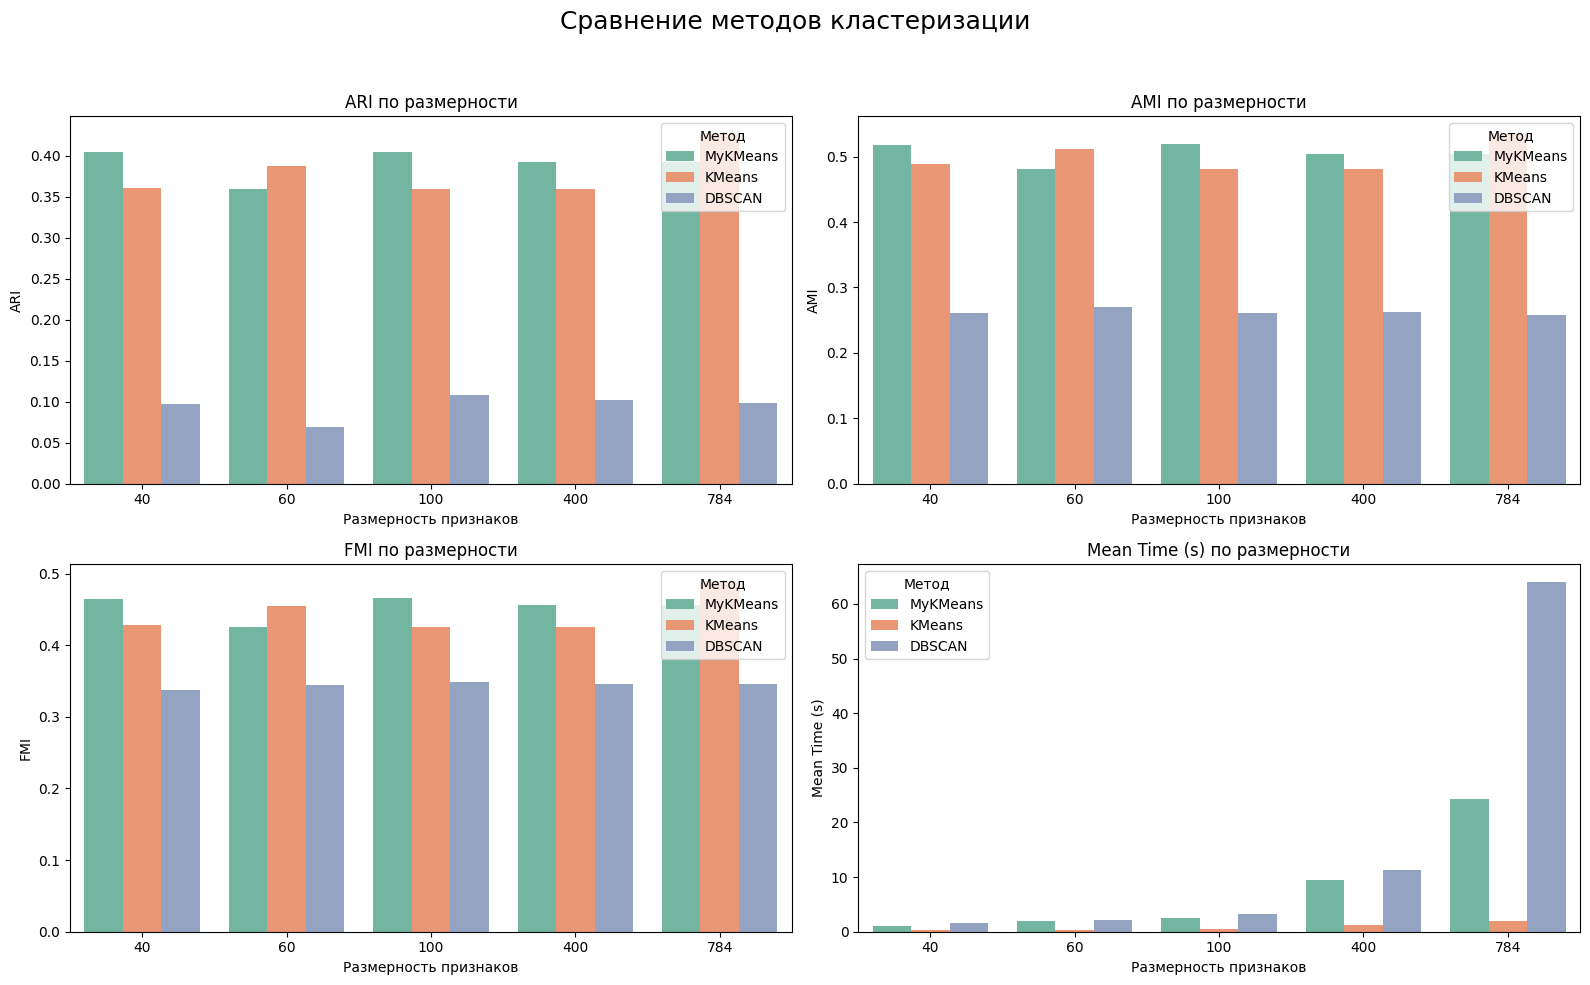

In [ ]:
results_df = pd.read_csv(OUTPUT_FILE)

metrics = ["ARI", "AMI", "FMI", "Mean Time (s)"]
num_metrics = len(metrics)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    sns.barplot(
        data=results_df,
        x="Features",
        y=metric,
        hue="Model",
        ax=axes[idx],
        errorbar=None,
        palette="Set2"
    )
    axes[idx].set_title(f"{metric} по размерности")
    axes[idx].set_xlabel("Размерность признаков")
    axes[idx].set_ylabel(metric)
    axes[idx].legend(title="Метод", loc="best")

fig.suptitle("Сравнение методов кластеризации", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()